In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from lib.optimizers import *
from lib.functions import *
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

## A simple function

$$M = 3, K = 2, p \in \R^M, \forall_{0 \leq i < N} \, x^{[i]} \in \R^K, \, y^{[i]} \in \R$$

$$f : \R^K \times \R^M \to \R, \qquad f(x, p) = p_0 x_0 + p_1 x_1 + p_2 $$

$$ D_pf(x, p) = \left[\frac{\partial f}{\partial p_0}(x, p), \frac{\partial f}{\partial p_1}(x, p), \frac{\partial f}{\partial p_2}(x, p)\right]^T = [x_0, x_1, 1]^T$$

$$ R : \R^M \to \R^N, \qquad R(p) = \left[f(x^{[i]}, p) - y^{[i]}\right]_{0 \leq i < N} $$

$$ DR(p) = \left[\frac{\partial f}{\partial p_j}(x^{[i]}, p)\right]_{0 \leq i < N, 0 \leq j < M}$$

In [19]:
xs = np.array([[1, 2], [2, 3], [3, 4], [4, 5]])
ys = np.array([1, 2, 3, 4])


def f(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return p[0] * x[0] + p[1] * x[1] + p[2]


def df(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return np.array([x[0], x[1], 1])


def residue(
    f: Callable[[np.ndarray, np.ndarray], np.ndarray],
    xs: np.ndarray,
    ys: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    fs = np.array([f(x, p) for x in xs])

    return fs - ys


def residue_jacobian(
    f: Callable[[np.ndarray, np.ndarray], np.ndarray],
    df: Callable[[np.ndarray, np.ndarray], np.ndarray],
    ys: np.ndarray,
    xs: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    dfs = np.array([df(x, p) for x in xs])

    return np.array([dfs[i] for i in range(len(xs))])

In [20]:
def R_value(p: np.ndarray) -> np.ndarray:
    return residue(f, xs, ys, p)

def R_derivative(p: np.ndarray) -> np.ndarray:
    return residue_jacobian(f, df, ys, xs, p)

R = Function(R_value, R_derivative, 3, 4)

In [21]:
# test that the function works properly
# p = np.array([1, 1, 1])
# R(p), R.differential(p)

## Hyperparameters

In [22]:
# p0 = np.random.randn(3)
p0 = np.array([1.5, 0.6, -3.14])
max_iter = 1000

## Gradient descent method

In [23]:
p, err = gradient_descent(R, p0, 1e-3, max_iter)
print(f"{p=}, {err=}")

p=array([ 0.67672106,  0.78771171, -2.12900935]), err=1.0992723948344676


In [24]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([0.12313514, 1.58756791, 3.05200069, 4.51643346])

## Gauss-Newton method

In [25]:
p, err = gauss_newton(R, p0, max_iter, silent=True)
print(f"{p=}, {err=}")

p=array([-0.08,  1.08, -1.08]), err=4.440892098500626e-16


In [26]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([1., 2., 3., 4.])

## Levenberg-Marquardt method

#### 1. Constant $\lambda_k$ sequence

In [27]:
lambda_param = 1e-3
optimizer = LevenbergMarquardt(
    R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
)

In [28]:
p, err = optimizer.optimize(p0, max_iter, step_type="solve")
print(f"{p=}, {err=}")

p=array([-0.08,  1.08, -1.08]), err=2.220446049250313e-16


In [29]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([1., 2., 3., 4.])

In [30]:
p, err = optimizer.optimize(p0, max_iter, step_type="least_squares")
print(f"{p=}, {err=}")

p=array([-0.08,  1.08, -1.08]), err=0.0


In [31]:
p, err = optimizer.optimize(p0, max_iter, step_type="ridge")
print(f"{p=}, {err=}")

p=array([-0.08,  1.08, -1.08]), err=4.440892098500626e-16


In [48]:
p, err = optimizer.optimize(p0, max_iter, step_type="cgnr")
print(f"{p=}, {err=}")

p=array([-0.08,  1.08, -1.08]), err=2.220446049250313e-16


#### 2. Sequence $\lambda_k$ decrasing when error is decreasing, and increasing otherwise

In [100]:
optimizer = LevenbergMarquardt(
    R=R,
    lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(
        lambda0=0.1, lambda_change=2
    ),
)
p, err = optimizer.optimize(p0, max_iter)
print(f"{p=}, {err=}")

p=array([-0.08,  1.08, -1.08]), err=2.220446049250313e-16


In [101]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([1., 2., 3., 4.])

In [102]:
p, err = optimizer.optimize(p0, max_iter, step_type="least_squares")
print(f"{p=}, {err=}")

p=array([-0.08,  1.08, -1.08]), err=2.220446049250313e-16


In [103]:
p, err = optimizer.optimize(p0, max_iter, step_type="ridge")
print(f"{p=}, {err=}")

p=array([-0.08,  1.08, -1.08]), err=0.0


### Helper functions

In [15]:
_infty = 1e32
_zero = 1e-32

def remove_nans_infs_and_zeros(arr):
    arr = np.array(arr)
    arr[np.isnan(arr)] = _infty
    arr[np.isinf(arr)] = _infty
    arr[arr == 0] = _zero
    return arr

## Test parameters

In [108]:
lambda_params = [10**i for i in range(-10, 3)]
p0s = [np.random.randn(3) for _ in range(10)]

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []

for i, lambda_param in enumerate(lambda_params):
    print(f"lambda_param: {lambda_param} ({i + 1}/{len(lambda_params)})")
    optimizer = LevenbergMarquardt(
        R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda_param, lambda_change=2)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gauss_newton(R=R, p0=p0, alpha=lambda_param, max_iter=max_iter)
        errs.append(err)
    errors_gauss_newton.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gradient_descent(R=R, p0=p0, alpha=lambda_param, max_iter=max_iter)
        errs.append(err)
    errors_gradient_descent.append(errs)

C:\Users\matip\AppData\Local\Temp\ipykernel_42448\172512811.py:9: RuntimeWarning: overflow encountered in scalar multiply
  return p[0] * x[0] + p[1] * x[1] + p[2]
C:\Users\matip\AppData\Local\Temp\ipykernel_42448\172512811.py:9: RuntimeWarning: overflow encountered in scalar add
  return p[0] * x[0] + p[1] * x[1] + p[2]
C:\Users\matip\AppData\Local\Temp\ipykernel_42448\172512811.py:9: RuntimeWarning: invalid value encountered in scalar add
  return p[0] * x[0] + p[1] * x[1] + p[2]


In [139]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_std_lm_const = np.std(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)
errors_std_lm_const = remove_nans_infs_and_zeros(errors_std_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_std_lm_mod = np.std(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)
errors_std_lm_mod = remove_nans_infs_and_zeros(errors_std_lm_mod)

errors_gn_mean = np.mean(errors_gauss_newton, axis=1)
errors_gn_std = np.std(errors_gauss_newton, axis=1)
errors_gn_mean = remove_nans_infs_and_zeros(errors_gn_mean)
errors_gn_std = remove_nans_infs_and_zeros(errors_gn_std)

errors_gd_mean = np.mean(errors_gradient_descent, axis=1)
errors_gd_std = np.std(errors_gradient_descent, axis=1)
errors_gd_mean = remove_nans_infs_and_zeros(errors_gd_mean)
errors_gd_std = remove_nans_infs_and_zeros(errors_gd_std)

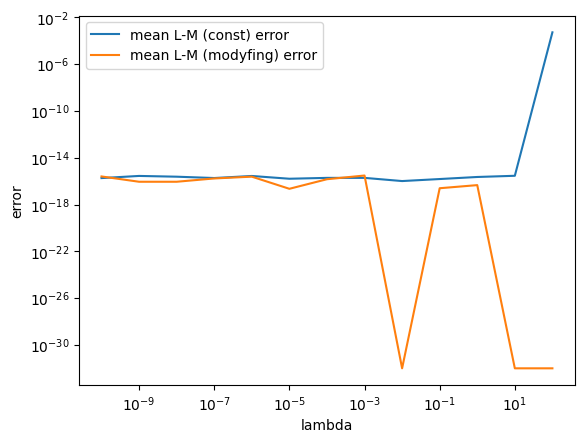

In [140]:
plt.loglog(lambda_params, errors_mean_lm_const, label="mean L-M (const) error")
# plt.loglog(lambda_params, errors_std_lm_const, label="L-M (const) error std", linestyle="--")

plt.loglog(lambda_params, errors_mean_lm_mod, label="mean L-M (modyfing) error")
# plt.loglog(lambda_params, errors_std_lm_mod, label="L-M (modyfing) error std", linestyle="--")

plt.legend()
plt.xlabel("lambda")
plt.ylabel("error")
plt.show()

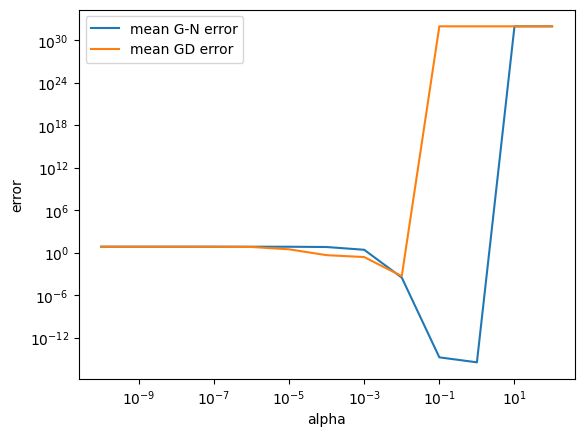

In [141]:
plt.loglog(lambda_params, errors_gn_mean, label="mean G-N error")
# plt.loglog(lambda_params, errors_gn_std, label="G-N error std", linestyle="--")

plt.loglog(lambda_params, errors_gd_mean, label="mean GD error")
# plt.loglog(lambda_params, errors_gd_std, label="GD error std", linestyle="--")

plt.legend()
plt.xlabel("alpha")
plt.ylabel("error")
plt.show()

## Test number of iterations

In [23]:
max_iters = [10**i for i in range(0, 5)]
p0s = [np.random.randn(3) for _ in range(3)]
alpha_gd = 1e-2
alpha_gn = 1
lambda0 = 1e-2
lambda_change = 2

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []

for i, max_iter in enumerate(max_iters):
    print(f"max_iter: {max_iter} ({i + 1}/{len(max_iters)})")
    optimizer = LevenbergMarquardt(
        R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=lambda_change)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gauss_newton(R=R, p0=p0, alpha=alpha_gn, max_iter=max_iter)
        errs.append(err)
    errors_gauss_newton.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gradient_descent(R=R, p0=p0, alpha=alpha_gd, max_iter=max_iter)
        errs.append(err)
    errors_gradient_descent.append(errs)

max_iter: 1 (1/5)
max_iter: 10 (2/5)
max_iter: 100 (3/5)
max_iter: 1000 (4/5)
max_iter: 10000 (5/5)


In [24]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_std_lm_const = np.std(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)
errors_std_lm_const = remove_nans_infs_and_zeros(errors_std_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_std_lm_mod = np.std(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)
errors_std_lm_mod = remove_nans_infs_and_zeros(errors_std_lm_mod)

errors_gn_mean = np.mean(errors_gauss_newton, axis=1)
errors_gn_std = np.std(errors_gauss_newton, axis=1)
errors_gn_mean = remove_nans_infs_and_zeros(errors_gn_mean)
errors_gn_std = remove_nans_infs_and_zeros(errors_gn_std)

errors_gd_mean = np.mean(errors_gradient_descent, axis=1)
errors_gd_std = np.std(errors_gradient_descent, axis=1)
errors_gd_mean = remove_nans_infs_and_zeros(errors_gd_mean)
errors_gd_std = remove_nans_infs_and_zeros(errors_gd_std)

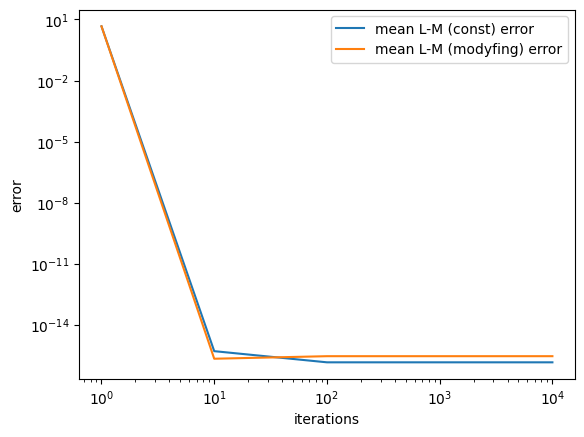

In [25]:
plt.loglog(max_iters, errors_mean_lm_const, label="mean L-M (const) error")
# plt.loglog(lambda_params, errors_std_lm_const, label="L-M (const) error std", linestyle="--")

plt.loglog(max_iters, errors_mean_lm_mod, label="mean L-M (modyfing) error")
# plt.loglog(lambda_params, errors_std_lm_mod, label="L-M (modyfing) error std", linestyle="--")

plt.legend()
plt.xlabel("iterations")
plt.ylabel("error")
plt.show()

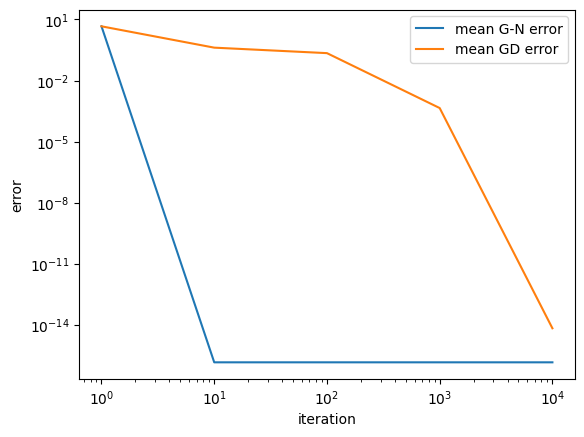

In [26]:
plt.loglog(max_iters, errors_gn_mean, label="mean G-N error")
# plt.loglog(lambda_params, errors_gn_std, label="G-N error std", linestyle="--")

plt.loglog(max_iters, errors_gd_mean, label="mean GD error")
# plt.loglog(lambda_params, errors_gd_std, label="GD error std", linestyle="--")

plt.legend()
plt.xlabel("iteration")
plt.ylabel("error")
plt.show()